# Finding your way in MIDAAs interface

The idea with which we conceived MIDAA was to give great flexibility in structuring the network and tuning most of the hyperparameters both at the level of architecture and inference. The very definition of the training interface is actually quite scary. But don't despair this notebook will tell you exactly what knobs move what. As nice as it is to have easy-to-use tools with few parameters, I am convinced that knowing exactly what you are running in great detail allows you to get better results and (maybe) learn something new.

Let us begin with a brief idea of how the package is structured: 
* First we have an interface function that allows us to do an entire training cycle at fixed parameters and takes care of almost everything.
* The probabilistic model is defined in Pyro and has a model function that describes the generative process and a driving function that describes the variational distributions for inference
* The two most important parts of the model, i.e., the decoder and encoder are implemented as modules of PyTorch 

We will go through these 3 blocks and what parameters you can tune in the interface. To show this we will use a simple unimodal single cell PBMC dataset (a real classic of single-cell methods' tutorials).


In [1]:
import sys
sys.path.append("../src/")

In [20]:
# You need scanpy for this tutorial 
import scanpy as sc
import midaa as maa
import numpy as np
import pandas as pd

adata =  sc.datasets.pbmc3k_processed()

/home/salvatore.milite/miniconda3/envs/scdeepaa/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


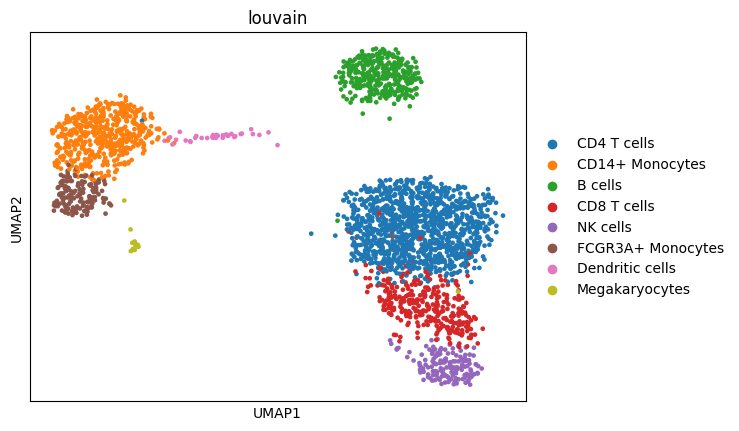

In [3]:
sc.pl.umap(adata, color="louvain")

Let me also introduce the 4 main parameters of MIDAA:
* The input data, it should be provided as a list of numpy arrays, one for each modality
* A normalization factor, this is especially useful when you work with raw counts. The normalization factors are modality specific and are applied before computing the likelihood. For instance if we call $\beta$ the output of the last layer of the decoder and the normalization factors as $\nu$ and our likelihood of choice is Poisson then the rate of the Poisson is gonna be computed as $exp(\beta) * \nu$.  
*  The likelihood used to compute the reconstruction loss of the data, we currently support: Gaussian (G), Poisson (P), Negative Binomial (NB), Categorical (C), Bernoulli (B), Beta (Beta). Again likelihoods are modality specific and are list of strings.
*  The number of archetypes to fit.

In [23]:
input_data = [adata.X] # as midaaa is designed for multiomics data you can still run on single modality but the input needs to be a list like [modality_1, modality_2, ...]
normalization_factor = [np.ones(adata.X.shape[0])]
likelihoods = ["G"]
narchetypes = 3

## Training Parameters

The two main parameters you can change are the number of steps and the learning rate. In our simulations we find that learning rates around 1e-3 and 1e-4 work well. Regarding the number of steps, they really depend on the problem but generally >500 is enough to get a decent model. We just want to highlight that for us a step menas a complete epoch, so the number of actual gradient iterations will be dependent on the batch size and number of samples.

In [12]:
res = maa.fit_MIDAA(
    input_data,
    normalization_factor,
    likelihoods,
    lr = 0.001,
    steps = 600,
    narchetypes = narchetypes
    )

ELBO: 29763494.00000  : 100%|██████████| 600/600 [00:12<00:00, 47.32it/s]
/home/salvatore.milite/miniconda3/envs/scdeepaa/lib/python3.11/site-packages/pyro/primitives.py:137: RuntimeWarning: trying to observe a value outside of inference at loss
  warnings.warn(


We see how our model converges nicely and recapitulates the 3 main celltype groups we have (T-cells, B-cells and monocyte/dendritic)

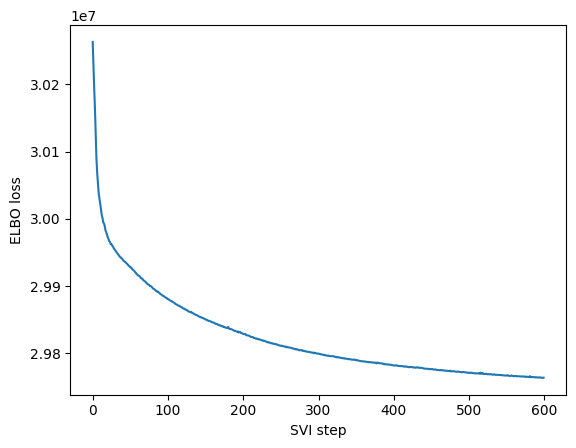

In [13]:
maa.plot_ELBO(res)

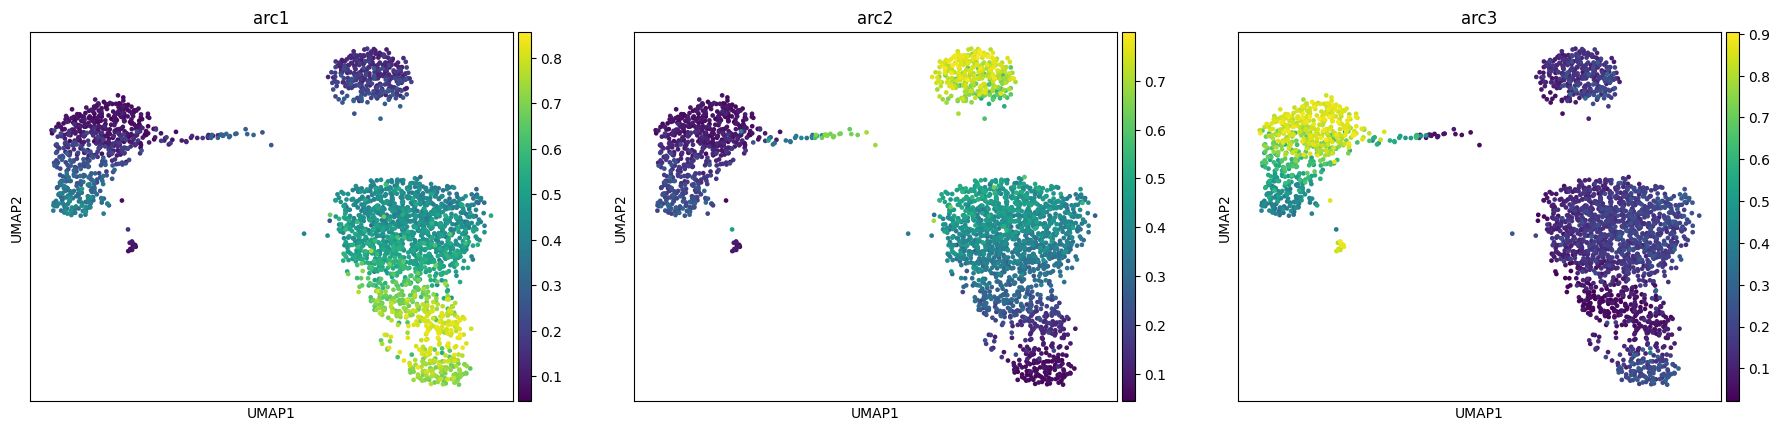

In [14]:
adata, arc_names = maa.add_to_obs_adata(res, adata)
sc.pl.umap(adata, color = arc_names)

In [15]:
# A high learning rate generates instabilities and lead to bad fits
res = maa.fit_MIDAA(
    input_data,
    normalization_factor,
    likelihoods,
    lr = 0.05,
    steps = 600,
    narchetypes = narchetypes
    )


ELBO: 29761718.00000  : 100%|██████████| 600/600 [00:12<00:00, 48.53it/s]


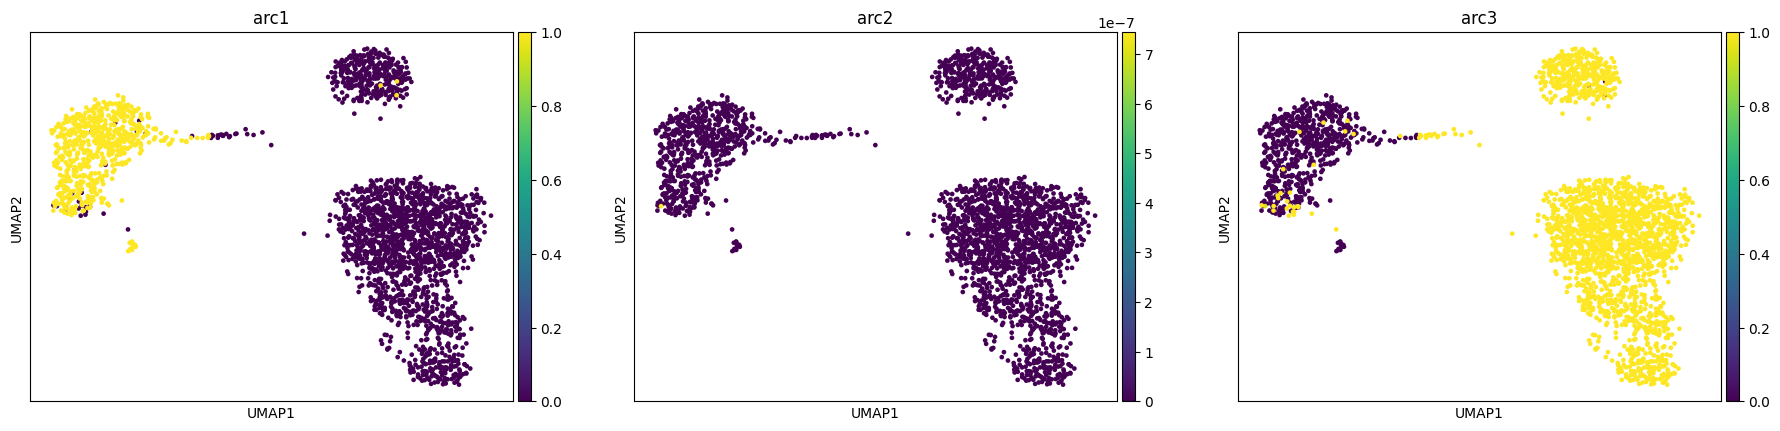

In [16]:
adata, arc_names = maa.add_to_obs_adata(res, adata)
sc.pl.umap(adata, color = arc_names)

In [20]:
# A low learning rate does not converge
res = maa.fit_MIDAA(
    input_data,
    normalization_factor,
    likelihoods,
    lr = 1e-6,
    steps = 600,
    narchetypes = narchetypes
    )

ELBO: 30254284.00000  : 100%|██████████| 600/600 [00:12<00:00, 48.09it/s]


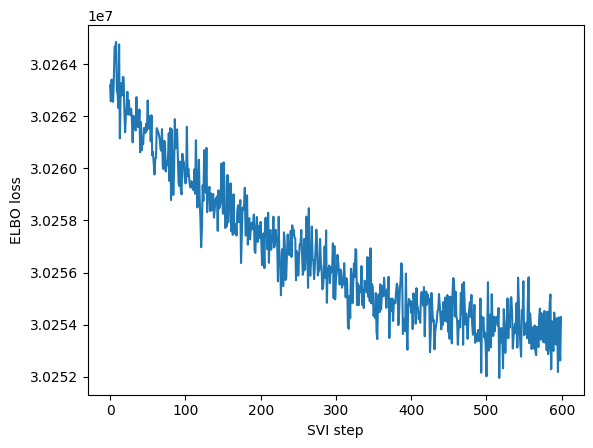

In [21]:
maa.plot_ELBO(res)

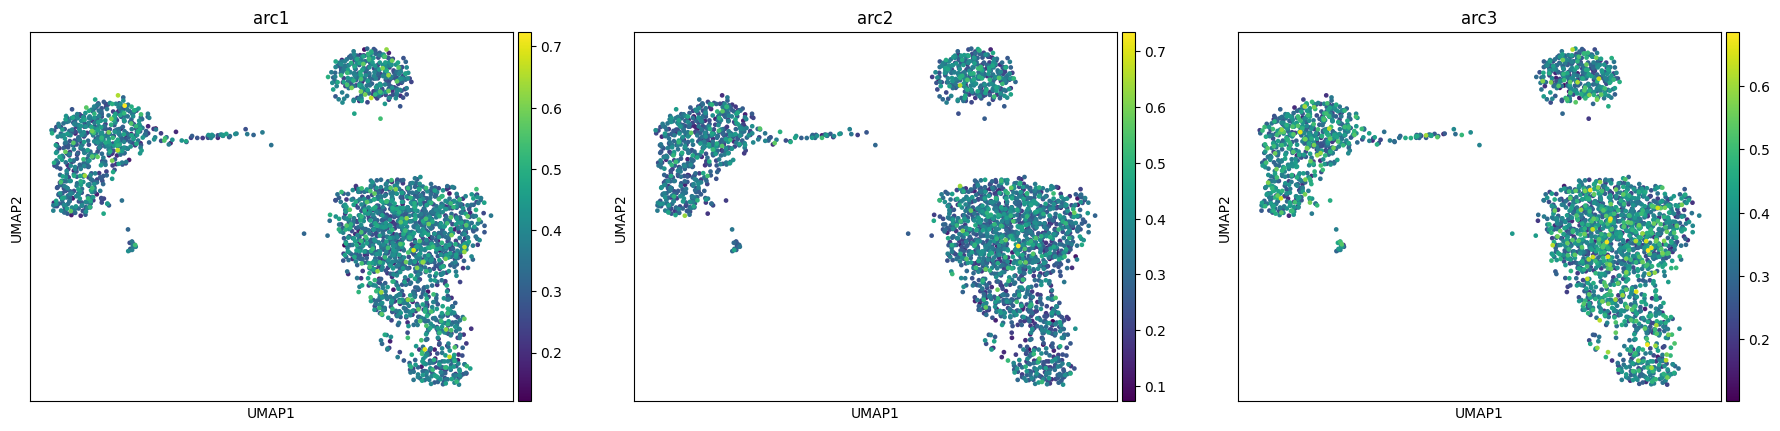

In [22]:
adata, arc_names = maa.add_to_obs_adata(res, adata)
sc.pl.umap(adata, color = arc_names)

In [25]:
# Same for a low number of steps
res = maa.fit_MIDAA(
    input_data,
    normalization_factor,
    likelihoods,
    lr = 0.001,
    steps = 10,
    narchetypes = narchetypes
    )

ELBO: 30122298.00000  : 100%|██████████| 10/10 [00:00<00:00, 45.33it/s]


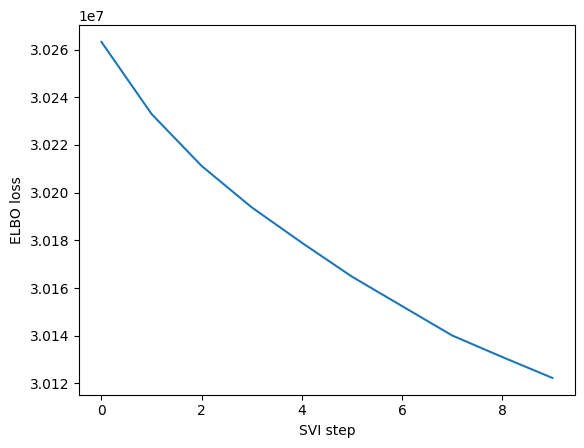

In [26]:
maa.plot_ELBO(res)

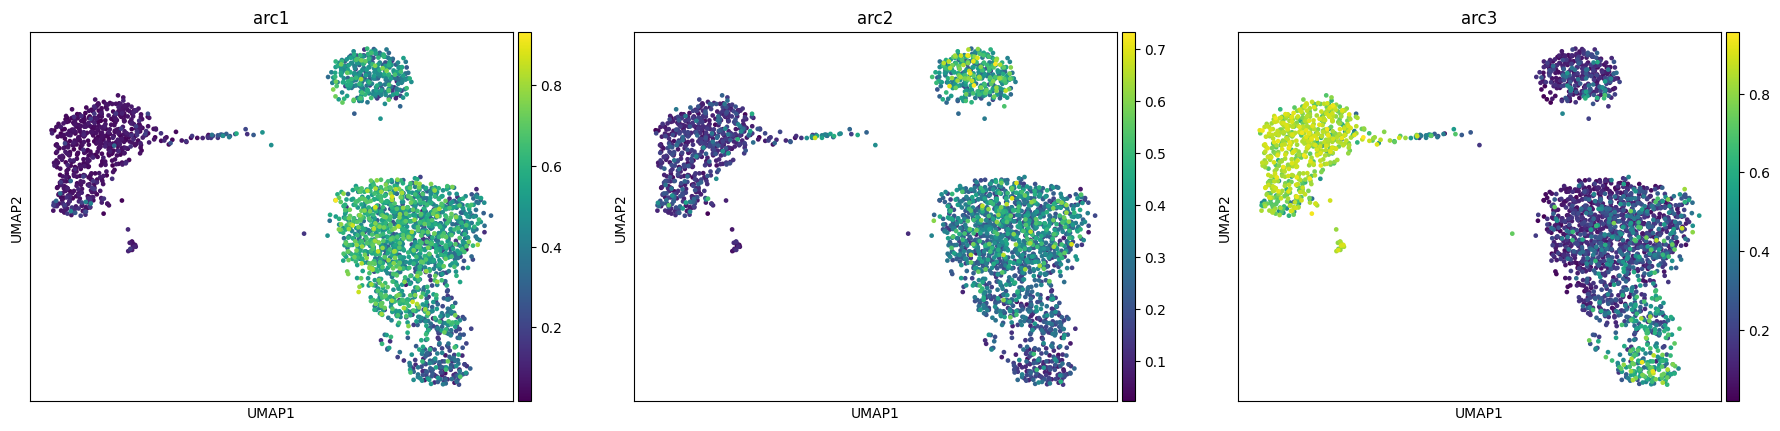

In [27]:
adata, arc_names = maa.add_to_obs_adata(res, adata)
sc.pl.umap(adata, color = arc_names)

The last 4 parameters we want to show in this section are quite important: the `gamma_lr` , the `setorch_seeded`, `batch_size` and the `CUDA` parameter. We will just explain what they do as it is quite striaghtforward:
* `torch_seed`: sets the torch seed to make the pseudonumber generation reproducible for that run
* `CUDA`: moves model fitting calculation on the GPU (highly suggested if you have a GPU)
* `batch_size` : the number of examples for each gradient update (beware that 1 step of the `steps` parameter is always a full epoch), you should set this parameter based on how big is the data and how powerfull is your hardware, generally batches that are too small make the convergence slow and relatively noisy.
* `gamma_lr`: in MIDAA we have an exponential learning rate schedule, the final learning rate will be `gamma_lr * lr`, while at each step `lr**(1/n_steps)`


## Model Parameters

MIDAA model does not have many parameters but the few it has are particularly important. We suggest to have at least some familiarity with this section before running the model on real data. The main three parameters of the model have already been defined at the start of this notebook: the number of archetypes, the normalization factors and, the likelihood distribution. Other 2 important parameters are `linearize_encoder` and `linearize_decoder`, they set respectively the encoder and the decoder as simple torch linear layers, without any activation function or regularization like wights dropout. 


In [8]:
res = maa.fit_MIDAA(
    input_data,
    normalization_factor,
    likelihoods,
    lr = 0.0005, 
    steps = 500,
    narchetypes = narchetypes,
    linearize_encoder = True,
    linearize_decoder = True
    )

ELBO: 29853852.00000  : 100%|██████████| 500/500 [00:42<00:00, 11.78it/s]
/home/salvatore.milite/miniconda3/envs/scdeepaa/lib/python3.11/site-packages/pyro/primitives.py:137: RuntimeWarning: trying to observe a value outside of inference at loss
  warnings.warn(


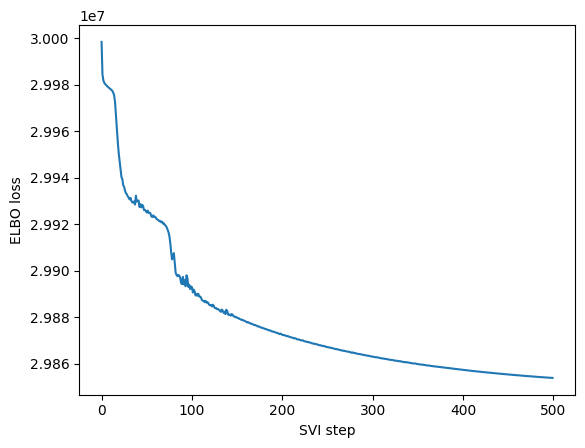

In [9]:
maa.plot_ELBO(res)

We see that while the reconstruction of the linear model is not as good as the non-linear one, it still able to get what is going on inside our sample. The main advantage of having a linear encoder or decoder is that we can recover all the nice properties of linear dimensionality reduction and it might help us against overfitting in simple scenario.

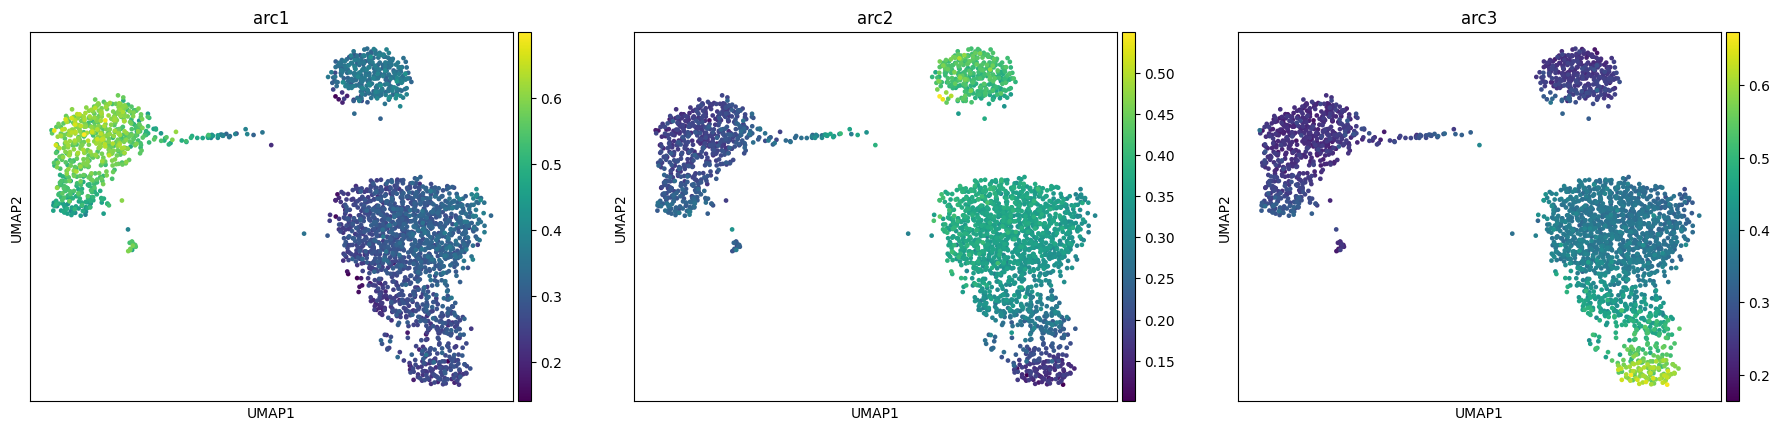

In [14]:
adata, arc_names = maa.add_to_obs_adata(res, adata)
sc.pl.umap(adata, color = arc_names)

We also implement two other models in the MIDAA package, one is based on a different latent space and loss formulation (more info in this other [tutorial](https://sottorivalab.github.io/daario/midaa_long_form.html) ) and one is a simple multi-modality VAE where we just learn the latent space with an isotrophic Gaussian prior.

Regarding the first case you have 2 parameters to tweak:
* `Z_fix_norm`: this is the most important one, is the portion of the loss that regularizes the inferred archetypes with the fixed ones, in general a value too big will make the A and B matrices very distant in terms of their archetypal representation, while a too big of a value will force the model to ignore the actual likelihood
* `Z_fix_release_step`: this is an added option to start relaxing the fixed archetypes after some iterations. The option is the number of epochs from which to start learning the fixed archetypes as a parameter.

In [10]:
res = maa.fit_MIDAA(
    input_data,
    normalization_factor,
    likelihoods,
    lr = 0.001, 
    steps = 500,
    fix_Z = True, # This let us select the model of Keller et al. 2019
    narchetypes = narchetypes,
    Z_fix_norm = 1e8, # I suggest you to play a bit with this parameter to see the effect on the final model 
    Z_fix_release_step = 400
    )

ELBO: 29795376.00000  : 100%|██████████| 500/500 [00:10<00:00, 46.53it/s]


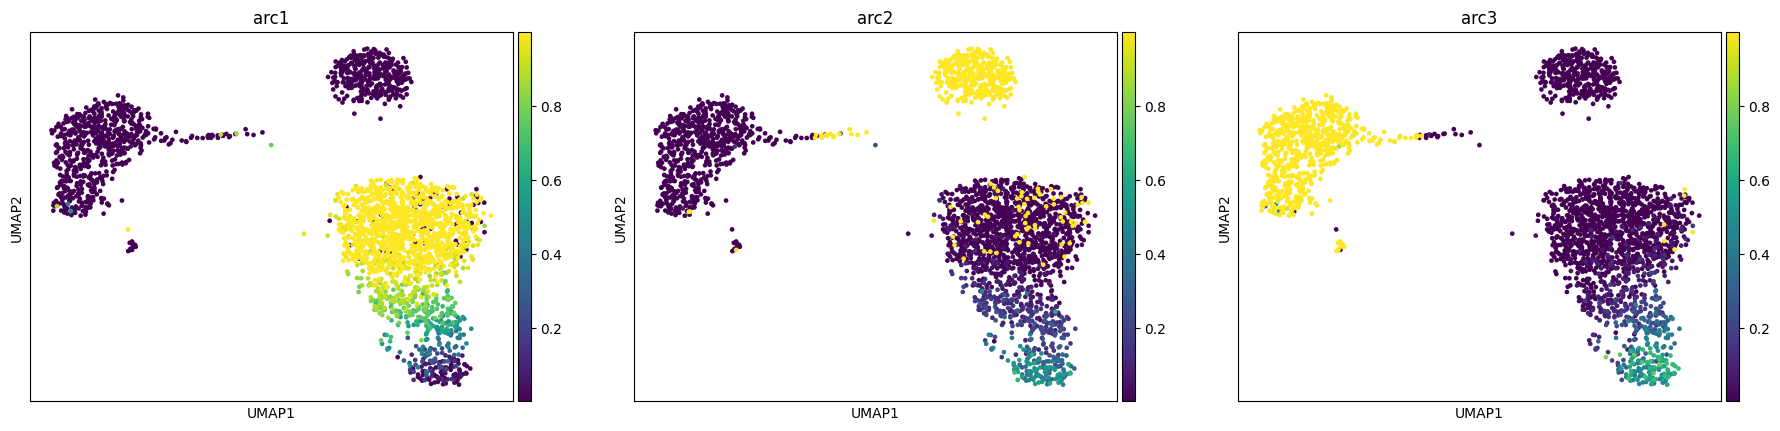

In [11]:
adata, arc_names = maa.add_to_obs_adata(res, adata)
sc.pl.umap(adata, color = arc_names)

For the variational autoencoder you just have to set to `True` the `just_VAE` option. Note that to control the number of hidden dimensions you still have to change the number of archetypes (even if AA is not actually performed). For instance if we want a latetn representation with 2 dimension we need to set the number of archetypes to 3 (and in general the number of latent dimensions is 1 minus the number of archetypes)

In [12]:
res = maa.fit_MIDAA(
    input_data,
    normalization_factor,
    likelihoods,
    lr = 0.001, 
    steps = 500,
    just_VAE = True, 
    narchetypes = narchetypes # Remember the number of  latent variables is 1 - narchetypes

    )

ELBO: 29764586.00000  : 100%|██████████| 500/500 [00:09<00:00, 54.18it/s]


Of course the archetypes here are completely randomic

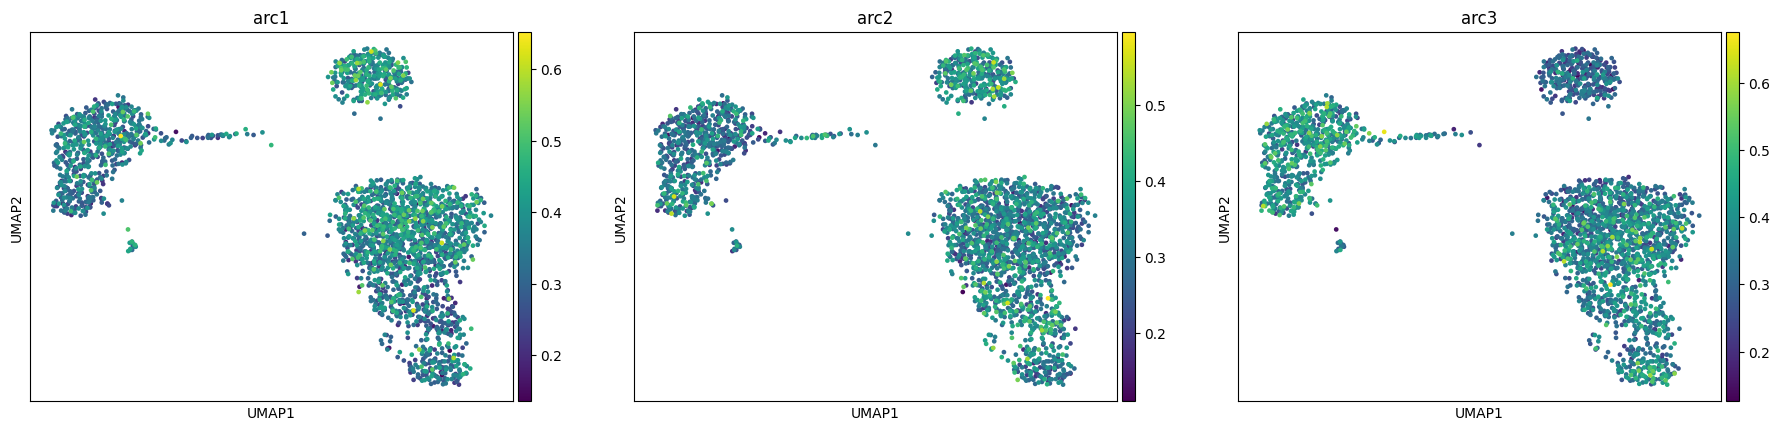

In [13]:
adata, arc_names = maa.add_to_obs_adata(res, adata)
sc.pl.umap(adata, color = arc_names)

But we cna visualize the latent space

/home/salvatore.milite/miniconda3/envs/scdeepaa/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


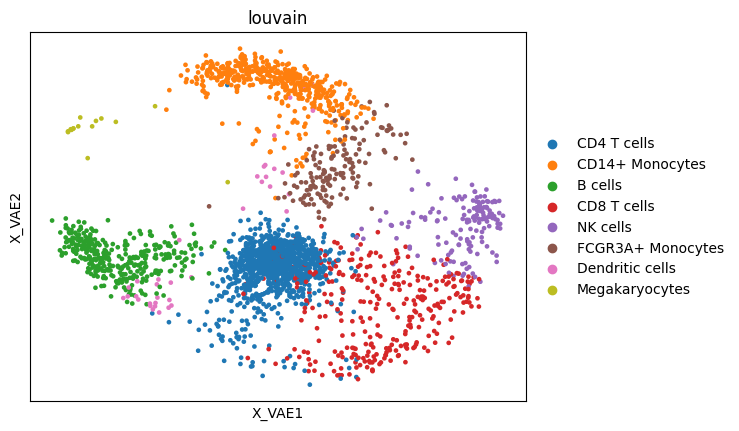

In [17]:
adata.obsm["X_VAE"] = res["inferred_quantities"]["Z"]

sc.pl.embedding(adata, "X_VAE", color = "louvain")

To conclude we will show how to use the classification/regression feature of MIDAA. The idea is that you might have side data that you want to either classify or regress (to use the model on test data) or you want their reconstructionto influence the archetype reconstruction but without encoding them (again generally to use the same model on other non annotated instances or to save memory and efficiency if you don't care about their encoding). Let me show you an example with the cell type labels

In [22]:
# We will get a one-hot encoded representation
side_mat = pd.get_dummies(adata.obs["louvain"], prefix='louvain') 
side_mat = side_mat.to_numpy().astype(float)

side_data = [side_mat] # similar to the input 
likelihoods_side = ["C"] # we need a likelihood for the side data, note that we do not have normalization (this is just a design choice to simplify the interface)

In [24]:
res = maa.fit_MIDAA(
    input_data,
    normalization_factor,
    likelihoods,
    side_matrices = side_data,
    input_types_side = likelihoods_side,
    lr = 0.001,
    steps = 600,
    narchetypes = narchetypes
    )

ELBO: 29750192.00000  : 100%|██████████| 600/600 [00:15<00:00, 39.01it/s]
/home/salvatore.milite/miniconda3/envs/scdeepaa/lib/python3.11/site-packages/pyro/primitives.py:137: RuntimeWarning: trying to observe a value outside of inference at loss
  warnings.warn(


This time we visualize the data by projecting the data into a 2d polytope, this is quite a good way to visualize the actual high dimensional simplex.

(<Figure size 640x480 with 1 Axes>, <PolarAxes: >)

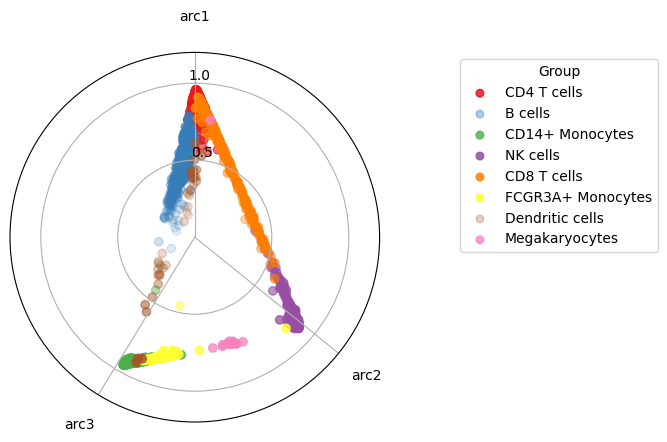

In [25]:
maa.plot_archetypes_simplex(res, color_by = adata.obs["louvain"], cmap = "Set1")

What I didn't tell you is that of course we have a parameter to scale the contribution to the likelihood of the side and the input data, by default they are divided by the number of feature to be in the same range, but you can of course modify it, let's see an example. Note how you can use the same parameters to weight the relative importance of each modality in the input and each side data. By default they are also rescaled based on the number of features they have (i.e. if you have RNA-seq with 30000 genes and methylation with 450k CpG islands and side data with a Categorical variable with 6 classes, the relative contributions are gonna be respectively 1/30000, 1/450k and 1/6)

In [28]:
res = maa.fit_MIDAA(
    input_data,
    normalization_factor,
    likelihoods,
    side_matrices = side_data,
    input_types_side = likelihoods_side,
    lr = 0.001,
    steps = 1000,
    narchetypes = 8, # the number of cell types we have
    loss_weights_side = [1], # loss normalization factor for the side data
    loss_weights_reconstruction = [0] # loss normalization factor for the input data
    )

ELBO: 23401272.00000  : 100%|██████████| 1000/1000 [00:24<00:00, 41.46it/s]
/home/salvatore.milite/miniconda3/envs/scdeepaa/lib/python3.11/site-packages/pyro/primitives.py:137: RuntimeWarning: trying to observe a value outside of inference at loss
  warnings.warn(


(<Figure size 640x480 with 1 Axes>, <PolarAxes: >)

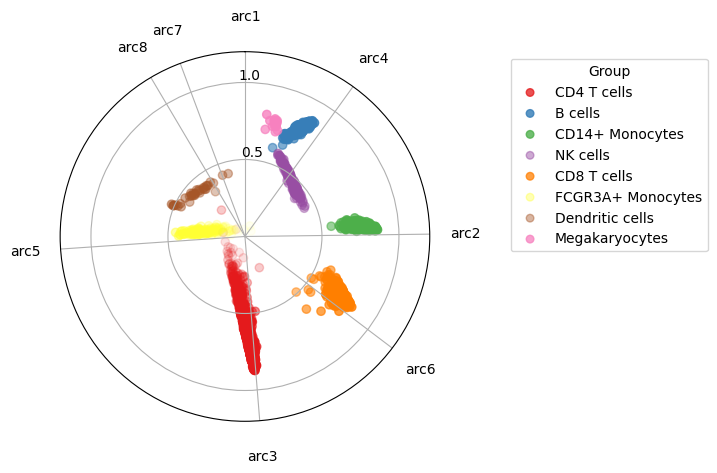

In [29]:
# See how the cell types are super separated
maa.plot_archetypes_simplex(res, color_by = adata.obs["louvain"], cmap = "Set1")

## Network parameters 

Up until now we did not care much about the network to go from the input to the latent representation and back, but the is also quite customizable.

For now the model supports just convolution and linear networks (though we plan to make that part general and give some constructors for commonly used networks). You can modify the dimension of the encoder in the 3 different points:
* `hidden_dims_enc_ind`:
* `hidden_dims_enc_common`:
* `hidden_dims_enc_pre_Z`:

While for the decoder:
* `hidden_dims_dec_common`:
* `hidden_dims_dec_last`:
* `hidden_dims_dec_last_side`:

We will not tweak all these parameters as the space is huge and show just an example where we specify them directly, we encourage you as usual to play with them by yourself.

In [31]:
res = maa.fit_MIDAA(
    input_data,
    normalization_factor,
    likelihoods,
    hidden_dims_enc_ind = [512],
    hidden_dims_enc_common = [256,128],
    hidden_dims_enc_pre_Z = [128, 64],
    hidden_dims_dec_common = [64,128],
    hidden_dims_dec_last = [256,512],
    lr = 0.001,
    steps = 600,
    narchetypes = narchetypes
    )

ELBO: 29773284.00000  : 100%|██████████| 600/600 [00:13<00:00, 45.43it/s]
/home/salvatore.milite/miniconda3/envs/scdeepaa/lib/python3.11/site-packages/pyro/primitives.py:137: RuntimeWarning: trying to observe a value outside of inference at loss
  warnings.warn(


(<Figure size 640x480 with 1 Axes>, <PolarAxes: >)

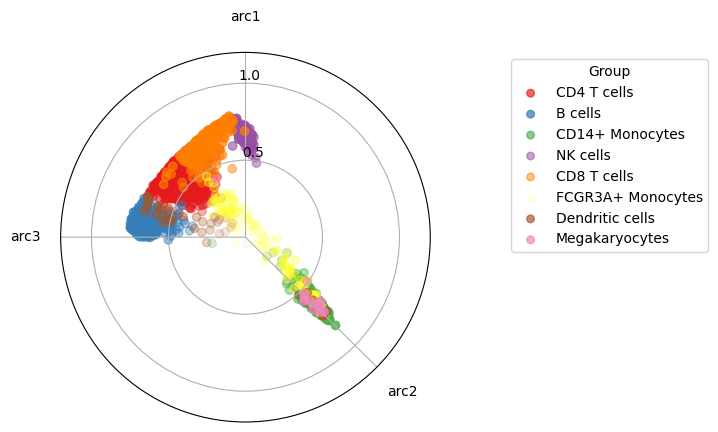

In [32]:
maa.plot_archetypes_simplex(res, color_by = adata.obs["louvain"], cmap = "Set1")

Last (but not least) is the type of encoder network that we support. On the long run my idea is to have the encoder and the decoder as external argument to the fitting function and to provide a set of constructor for some common cases (DNN, CNN, Transformers, etc...), but for now we support fully connected and convolutional neurat networks. We will move for a second from the world of single-cell and omics data a go back to our lovely MNIST (BTW we need a general DataLoader, if you have suggestions open an Issue please).

In [51]:
from pyro.contrib.examples.util import MNIST
import torchvision.transforms as transforms
import torch


images = MNIST(root="data",  transform = transforms.ToTensor(),
                      download=True)

In [84]:
# let's get an example 1000 images

images_train = torch.cat([images[i][0] for i in range(1000)],dim = 0).reshape([1000, 1, 28, 28]).numpy()

In [93]:
torch.tensor(images_train).shape

torch.Size([1000, 1, 28, 28])

In [92]:
res = maa.fit_MIDAA(
    [images_train],
    [np.ones(images_train.shape[0])],
    ["G"],
    layers_independent_types = ["conv"], # here we specify that we want a convolutional encoder and decoder
    hidden_dims_enc_ind = [8, 16, 32], # now that indicates the number of channels of the encoder
    hidden_dims_enc_common = [256],
    hidden_dims_enc_pre_Z = [128, 64],
    hidden_dims_dec_common = [64,128],
    hidden_dims_dec_last = [32, 16, 8], # this is the number of channels of the decoder
    lr = 0.001,
    steps = 600,
    narchetypes = 5, # We just set a random number here
    batch_size = 128,
    image_size = [28,28], # HxW of the image
    kernel_size=3, 
    stride=1, 
    padding=2, 
    pool_size=2, 
    pool_stride=2
    )

Bar desc:   0%|          | 0/600 [00:00<?, ?it/s]


RuntimeError: mat1 and mat2 shapes cannot be multiplied (128x288 and 30752x256)
                                  Trace Shapes:                
                                   Param Sites:                
             encoder$$$layers_common.0.0.weight       256 30752
               encoder$$$layers_common.0.0.bias             256
             encoder$$$layers_common.0.2.weight             256
               encoder$$$layers_common.0.2.bias             256
encoder$$$layers_independent_input.0.0.0.weight  8  1   3     3
  encoder$$$layers_independent_input.0.0.0.bias               8
encoder$$$layers_independent_input.0.1.0.weight 16  8   3     3
  encoder$$$layers_independent_input.0.1.0.bias              16
encoder$$$layers_independent_input.0.2.0.weight 32 16   3     3
  encoder$$$layers_independent_input.0.2.0.bias              32
           encoder$$$layers_latent.0.0.0.weight       128   256
             encoder$$$layers_latent.0.0.0.bias             128
           encoder$$$layers_latent.0.0.2.weight             128
             encoder$$$layers_latent.0.0.2.bias             128
           encoder$$$layers_latent.0.1.0.weight        64   128
             encoder$$$layers_latent.0.1.0.bias              64
           encoder$$$layers_latent.0.1.2.weight              64
             encoder$$$layers_latent.0.1.2.bias              64
             encoder$$$layers_latent.0.2.weight         5    64
               encoder$$$layers_latent.0.2.bias               5
           encoder$$$layers_latent.1.0.0.weight       128   256
             encoder$$$layers_latent.1.0.0.bias             128
           encoder$$$layers_latent.1.0.2.weight             128
             encoder$$$layers_latent.1.0.2.bias             128
           encoder$$$layers_latent.1.1.0.weight        64   128
             encoder$$$layers_latent.1.1.0.bias              64
           encoder$$$layers_latent.1.1.2.weight              64
             encoder$$$layers_latent.1.1.2.bias              64
             encoder$$$layers_latent.1.2.weight         5    64
               encoder$$$layers_latent.1.2.bias               5
           encoder$$$layers_latent.2.0.0.weight       128   256
             encoder$$$layers_latent.2.0.0.bias             128
           encoder$$$layers_latent.2.0.2.weight             128
             encoder$$$layers_latent.2.0.2.bias             128
           encoder$$$layers_latent.2.1.0.weight        64   128
             encoder$$$layers_latent.2.1.0.bias              64
           encoder$$$layers_latent.2.1.2.weight              64
             encoder$$$layers_latent.2.1.2.bias              64
             encoder$$$layers_latent.2.2.weight         4    64
               encoder$$$layers_latent.2.2.bias               4
                                  Sample Sites:                